In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import h5py
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import signal
import time

In [2]:
avgMat = loadmat('avgMat.mat')
avgMatData = [[element for element in upperElement] for upperElement in avgMat['avgMat']]
#Data is stored as a list of lists of lists (35x5x817)
print(type(avgMatData))
print(len(avgMatData))
print(len(avgMatData[1]))
print(len(avgMatData[1][1]))

<class 'list'>
35
5
817


In [3]:
evMat = loadmat('evMat.mat')
evMatData = [[element for element in upperElement] for upperElement in evMat['evMat']]

V = evMatData[0][0][0]
t = evMatData[0][0][1]
evLog = evMatData[0][0][2]
#t is a numpy array of 817 values (corresponding to those in V)
#V is a numpy array of numpy arrays of numpy arrays of numpy arrays representing a 4D vector (5 x 8 x 817 x 500)
#evLog is... uhhh... not too sure tbh, its a mess. If need be I'll parse it but I don't think it really matters for us.

In [4]:
ex1 = loadmat('ex1.mat')
ex1Data = [[element for element in upperElement] for upperElement in ex1['ex1']]
#First 5 data files raw data stored as a list of:
#'filename': String vector
#'rawData': list of lists containing V, t, and log - see ev for info on how to parse this, is essentially the same.
#'processedData': Empty vector
#'referenceTrace': List of lists containing V, t, and log - parsing is essentially the same as ev
#'eventTimeSample': List of one list containing the times(unconverted)
#'eventTime': List of one list containing the times(converted)
#'samplingFrequency' list of one value with the sampling frequency in Hz

ex2 = loadmat('ex2.mat')
ex2Data = [[element for element in upperElement] for upperElement in ex2['ex2']]
#Last 5 data files raw data stored in the same way as ex1

In [5]:
print(ex2Data[0][1])

(array(['C:\\Users\\Raghav Acharya\\OneDrive\\Desktop\\Stuff\\Important Things\\College\\Classes\\08 - Spring 2021\\CX 4240 Desktop\\Project\\Data\\Michael_stimD3_recMedian_position7_ref2_100us_pos20mA(000).raw'],
      dtype='<U188'), array([[(array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.00962835, -0.00963092, -0.0096365 , ..., -0.00974973,
         -0.00974939, -0.00974683],
        ...,
        [-0.00828533, -0.00828634, -0.00829047, ..., -0.00825887,
         -0.00825987, -0.00825697],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.01826454, -0.01826632, -0.01826498, ..., -0.01801507,
         -0.01801597, -0.01801195],
        [-0.01287025, -0.0

In [6]:
def parseEx(mat,fileNum,info):
    if info == 'filename':
        return mat[0][fileNum][0]
    elif info == 'rawData':
        V = mat[0][fileNum][1][0][0][0]
        t = mat[0][fileNum][1][0][0][1]
        log = mat[0][fileNum][1][0][0][2]
        return V,t,log
    elif info == 'processedData':
        return mat[0][fileNum][2]
    elif info == 'referenceTrace':
        V = mat[0][fileNum][1][0][0][0]
        t = mat[0][fileNum][1][0][0][1]
        log = mat[0][fileNum][1][0][0][2]
        return V,t,log
    elif info == 'eventTimeSample':
        return mat[0][fileNum][4]
    elif info == 'eventTime':
        return mat[0][fileNum][5]
    elif info == 'samplingFrequency':
        return mat[0][fileNum][6]
    
#Function for parsing Ex file. May be useful when we need to start referencing these variables several times.

In [7]:
#Example of using this function:
#  I'll use the parseEx function to get the V,t,log data for the reference trace for the second file in the ex2Data
#  (7th file total)
(V,t,log) = parseEx(ex2Data,2,'referenceTrace')
print(t)

[[0.00000000e+00]
 [6.25000000e-05]
 [1.25000000e-04]
 ...
 [5.24998125e+01]
 [5.24998750e+01]
 [5.24999375e+01]]


In [8]:
evCA = loadmat('evCA.mat')
evCAData = [[element for element in upperElement] for upperElement in evCA['evCA']]
print(len(evCAData))
print(len(evCAData[0]))
print(len(evCAData[0][3]))
#Data is stored in a list (35 long) of lists (each 5 long) which represent the position on the arm
#Each of these lists has a list(817 long) of lists(500 to 1500 long depending on position)
# which give the average voltage per time.
#Image below might help organize a little bit. The overall array is the positions of each sensor, 
#and the individual arrays within are the voltage vs sample time readings.
print(evCAData)

35
5
817
[[array([], shape=(1, 0), dtype=float64), array([[ 3.48400000e-06, -3.23088889e-06, -1.59311111e-06, ...,
        -1.89088889e-06, -4.22100000e-06,  8.91844444e-06],
       [ 1.02733333e-06, -4.39222222e-07,  3.43188889e-06, ...,
        -6.13422222e-06, -3.10433333e-06,  7.02011111e-06],
       [ 2.59066667e-06,  4.25077778e-06,  5.28555556e-07, ...,
        -8.85888889e-07, -2.01000000e-07,  6.68511111e-06],
       ...,
       [ 1.30873333e-05, -3.09242222e-05, -1.29831111e-05, ...,
         2.62491111e-05,  4.82400000e-06, -3.07232222e-05],
       [ 6.83400000e-06, -2.98075556e-05, -9.63311111e-06, ...,
         3.04924444e-05,  7.61566667e-06, -2.70382222e-05],
       [ 5.71733333e-06, -3.13708889e-05, -1.07497778e-05, ...,
         2.66957778e-05,  8.06233333e-06, -2.60332222e-05]]), array([[ 1.61544444e-06,  1.57822222e-06, -2.13655556e-06, ...,
        -1.18366667e-06,  3.03733333e-06,  9.35766667e-06],
       [-1.73455556e-06,  6.60322222e-06,  2.10677778e-06, ...,
   

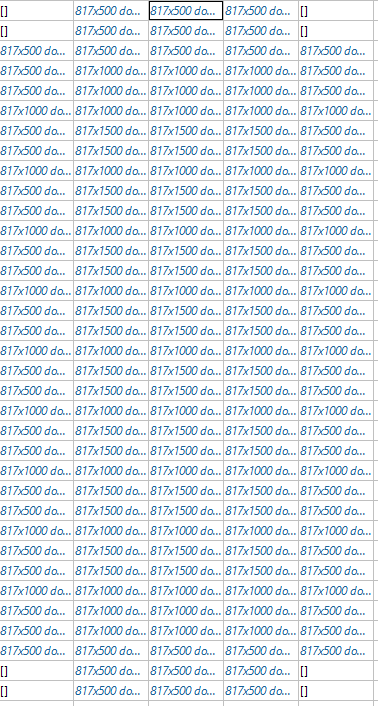

In [9]:
def EAtTime(tIdx,data = evCAData):
    EVout = np.zeros(shape=(len(data),len(data[0])))
    for depth in range(len(data)):
        for length in range(len(data[depth])):
            tempData = data[depth][length]
            #print(tempData)
            #print(len(tempData))
            if len(tempData) == 1:
                EVout[depth,length] = 0;
            else:
                EVout[depth,length] = np.mean(tempData[tIdx,:])
            
    return EVout

In [10]:
EVout = EAtTime(40)
print(EVout)
print(len(EVout))

[[ 0.00000000e+00  8.66789422e-06  8.12973533e-06  6.51985933e-06
   0.00000000e+00]
 [ 0.00000000e+00  9.17164489e-06  9.34621711e-06  1.14785740e-05
   0.00000000e+00]
 [ 7.43440933e-06  8.41555733e-06  9.53276000e-06  1.17061358e-05
   1.39513058e-05]
 [ 7.73909556e-06  8.60037311e-06  6.09327778e-06  1.02143212e-05
   1.06290587e-05]
 [ 4.96671000e-06  6.51661356e-06  6.02507178e-06  6.71105500e-06
   6.35079600e-06]
 [ 4.25243044e-06  5.04582211e-06  4.39571367e-06  5.65182222e-06
   2.50951478e-06]
 [ 4.56934044e-06  3.22197044e-06  1.85358230e-06  2.30219941e-06
   3.01354089e-06]
 [ 1.73226267e-06 -2.58287481e-07  3.86282296e-07  1.73440667e-07
   6.90546667e-07]
 [-9.35662444e-07 -7.08562222e-07 -1.03556689e-06 -1.00974211e-06
  -1.66820322e-06]
 [-1.83706556e-06 -9.77108148e-07 -1.44229163e-06 -1.34424830e-06
  -3.01742689e-06]
 [-3.92341578e-06 -2.84669600e-06 -2.60857800e-06 -2.39737415e-06
  -3.99888756e-06]
 [-3.84425156e-06 -3.25407833e-06 -3.36874511e-06 -3.39883556e-06

In [11]:
#%matplotlib

In [12]:
print(len(EVout[0]))

5


In [75]:
t1 = time.perf_counter()

maxT = 160
MaxNumClusters = 5
centroids = []
allModels = []
allInertias = []
numClustersUsed = []
for t in range(maxT):
    EVout = EAtTime(t,data = evCAData)
    evLin = []
    peaks = []
    peakData = []
    CwTData = []
    
    for length in range(len(EVout[0])):
        foundPeaks, _ = signal.find_peaks(EVout[:,length],height=(None, 0))#
        for p in range(len(foundPeaks)):
            peakData = peakData + [np.array([foundPeaks[p],length,EVout[foundPeaks[p],length]])]
        peaks = peaks + [np.array(foundPeaks)]
        #foundCwtPeaks = signal.find_peaks_cwt(EVout[:,length],np.arange(0.1,100))
        #for p in range(len(foundCwtPeaks)):
        #    CwTData = CwTData + [np.array([foundCwtPeaks[p],length,EVout[foundPeaks[p],length]])]
            
    
    #print(peaks)
    #print(np.array(peakData))
    for depth in range(len(EVout)):
        #print(depth)
        #
        for length in range(len(EVout[depth])):
            evLin = evLin + [np.array([depth, length, EVout[depth,length]])]
    evLin = np.array(evLin)
    #print(peaks)
    models = [];
    inertias = [];
    difInertias = [];
    tempCentrs = [];
    #print(evLin)
    #if t == 0:
    #    fig = plt.figure()
    #    ax = fig.add_subplot(projection='3d')
    #    
    #    ax.scatter(evLin[:,0], evLin[:,1], evLin[:,2])
    #    ax.set_title(str(t))
    #    stop
    #print(len(peakData))
    for cluster in range(MaxNumClusters):
        #print(cluster)
        if len(peakData) == 0:
            tempCentrs = tempCentrs + [np.array(peakData)]
            difInertias = difInertias + [-10]
        elif len(peakData) > cluster:
            kmeans = KMeans(n_clusters= cluster+1, random_state=0).fit(peakData)
            models = models + [kmeans]
            inertias = inertias + [kmeans.inertia_]
            tempCentrs = tempCentrs + [np.array(kmeans.cluster_centers_)]
            if cluster+1 == 1:
                difInertias = difInertias + [0]
            else:
                difInertias = difInertias + [inertias[-1]-inertias[-2]]
        
    #plt.plot(range(MaxNumClusters),inertias)
    #plt.show()
    #plt.plot(range(MaxNumClusters),difInertias)
    #plt.show()
    optInertia = np.argmin(difInertias)
    #optInertia = 6
    #chosenModel = models[optInertia]
    
    #allModels = allModels + [chosenModel]
    centroids = centroids + [tempCentrs[optInertia]]
    #if t == 2:
    #    print(centroids)
    #    stop
    #print(chosenModel.cluster_centers_)
    #allInertias = allInertias + [chosenModel.inertia_]
    numClustersUsed = numClustersUsed + [optInertia]

#centroids = np.array([np.array(xi) for xi in centroids])
t2 = time.perf_counter()
print('KMeans time:')
print(str(t2-t1))

KMeans time:
24.346702599985292


5e-07


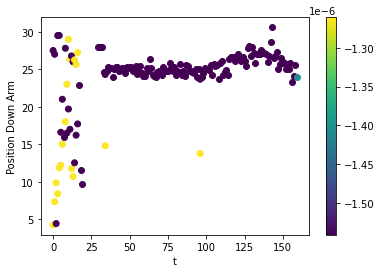

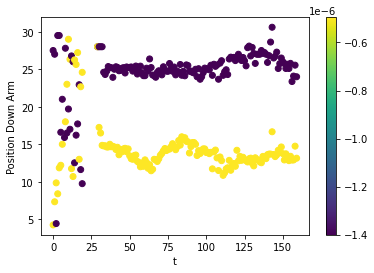

In [76]:
tol = 5*10**-7
print(tol)
#print(centroids)
#print(numClustersUsed)
posns = [];
adjTs = [];
plt.figure
for t in range(len(centroids)):
    #print([t]*len(centroids[t]))
    #print(centroids[t])
    #print(centroids[t][:,2])
    #hiPk = np.argmin(centroids[t][:,2])
    #print(hiPk)
    #stop
    if len(centroids[t]) > 0:
        hiPk = np.argmin(centroids[t][:,2])
        loPk = np.argmax(centroids[t][:,2])
        if abs(centroids[t][hiPk,2] - centroids[t][loPk,2]) > tol:
            plt.scatter([t],centroids[t][hiPk,0],c=centroids[t][hiPk,2])
            posns = posns + [centroids[t][hiPk,0]]
            adjTs = adjTs + [t]
            #print([t],centroids[t][hiPk,0], centroids[t][hiPk,2])
        else:
            plt.scatter([t]*len(centroids[t]),centroids[t][:,0],c=centroids[t][:,2])
            posns = posns + [np.mean(centroids[t][:,0])]
            adjTs = adjTs + [t]
            #print([t], centroids[t][:,0], centroids[t][:,2])
            #plt.scatter([t],np.mean(centroids[t][:,0]))
    #if len(centroids[t]) > 0:
    #    plt.scatter([t]*len(centroids[t]),centroids[t][:,0])
#plt.plot(adjTs,posns)
plt.xlabel('t')
plt.ylabel('Position Down Arm')
plt.colorbar()
plt.show()
for t in range(len(centroids)):
    #print([t]*len(centroids[t]))
    #print(centroids[t])
    #print(centroids[t][:,2])
    #hiPk = np.argmin(centroids[t][:,2])
    #print(hiPk)
    #stop
    if len(centroids[t]) > 0:
        hiPk = np.argmin(centroids[t][:,2])
        loPk = np.argmax(centroids[t][:,2])
        #if abs(centroids[t][hiPk,2] - centroids[t][loPk,2]) > tol:
        #plt.scatter([t],centroids[t][hiPk,0],c=centroids[t][hiPk,2])
        #posns = posns + [centroids[t][hiPk,0]]
        #adjTs = adjTs + [t]
        #print([t],centroids[t][hiPk,0], centroids[t][hiPk,2])
        #else:
        plt.scatter([t]*len(centroids[t]),centroids[t][:,0],c=centroids[t][:,2])
        posns = posns + [np.mean(centroids[t][:,0])]
        adjTs = adjTs + [t]
            #print([t], centroids[t][:,0], centroids[t][:,2])
            #plt.scatter([t],np.mean(centroids[t][:,0]))
    #if len(centroids[t]) > 0:
    #    plt.scatter([t]*len(centroids[t]),centroids[t][:,0])
#plt.plot(adjTs,posns)
plt.xlabel('t')
plt.ylabel('Position Down Arm')  
plt.colorbar()
plt.show()
#plt.figure
#for t in range(len(centroids)):
#    plt.scatter(t,len(centroids[t]))
#plt.show()

In [72]:
vec = np.array([np.array([0, 1, 0.45335]),np.array([1, 1, 0.43342]),np.array([1, 1, 0.92238472]),np.array([0, 2, 0.2323]),np.array([1, 2, 0.8738]),np.array([2, 2, 0.1323])])
print(vec)
kmeans = KMeans(n_clusters=2, random_state=0).fit(vec)
print('labels')
print(kmeans.labels_)
print('Cluster Centers')
print(kmeans.cluster_centers_)
print('inertia')
print(kmeans.inertia_)

[[0.         1.         0.45335   ]
 [1.         1.         0.43342   ]
 [1.         1.         0.92238472]
 [0.         2.         0.2323    ]
 [1.         2.         0.8738    ]
 [2.         2.         0.1323    ]]
labels
[0 1 1 0 1 1]
Cluster Centers
[[0.         1.5        0.342825  ]
 [1.25       1.5        0.59047618]]
inertia
2.699459272749909


[  6  13  18  24  29  36  38  43  50  57  64  71  78  85  93  99 101 107
 115 121 129 136 143 149 151 157]


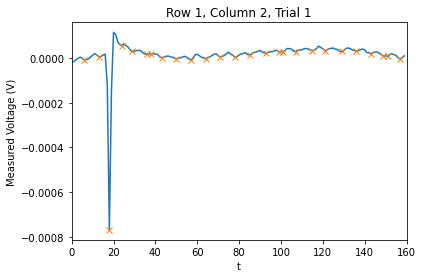

In [89]:
plt.figure
testx = evCAData[0][2]
testx_np = np.array([np.array(xi) for xi in testx])
foundPeaks, _ = signal.find_peaks(-testx_np[0:160,5])
print(foundPeaks)
plt.plot(testx_np[0:160,5])
plt.plot(foundPeaks, testx_np[foundPeaks,5], "x")
plt.xlabel('t')
plt.ylabel('Measured Voltage (V)')
plt.title('Row 1, Column 2, Trial 1')
plt.xlim([0,160])
plt.show()

[  1   4   6   9  14  18  22  27  30  33  37  43  47  52  55  61  63  65
  67  69  73  77  81  83  86  89  95  98 101 105 108 110 112 115 120 124
 128 131 137 141 143 145 148 150 152 155]


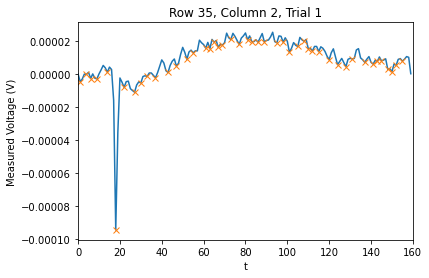

In [88]:
plt.figure
testx = evCAData[34][2]
testx_np = np.array([np.array(xi) for xi in testx])
foundPeaks, _ = signal.find_peaks(-testx_np[0:160,5])
print(foundPeaks)
plt.plot(testx_np[0:160,5])
plt.plot(foundPeaks, testx_np[foundPeaks,5], "x")
plt.xlabel('t')
plt.ylabel('Measured Voltage (V)')
plt.title('Row 35, Column 2, Trial 1')
plt.xlim([0,160])
plt.show()